In [1]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc

Using TensorFlow backend.


In [20]:
def build_rand_feat():
    x = []
    y = []
    _min, _max = float('inf'),-float('inf')
    #뉴럴 네트워크에선 보통 결과값을 0~1로 정제하기떄문에
    #min max값을 아는것이 중요하다.
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p=prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate, wav = wavfile.read('test_clean/'+file)
        label = df.at[file,'label']
        rand_index = np.random.randint(0,wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        x_sample = mfcc(sample, rate,
                       numcep=config.nfeat, nfft=config.nfft).T
        _min = min(np.amin(x_sample), _min)
        _max = max(np.amin(x_sample), _max)
        x.append(x_sample if config.mode == 'conv' else x_sample.T)
        y.append(classes.index(label))
    x, y = np.array(x), np.array(y)
    x = (x- _min) / (_max - _min)
    if config.mode == 'conv':
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
    elif config.mode == 'time':
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2])
    y = to_categorical(y, num_classes=10)
    
    return x,y

In [3]:
def get_recurrent_model():
    #shape of data for RNN is (n, time, feat)
    model = Sequential()
    model.add(LSTM(128, return_sequences=True ,input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(8, activation='relu')))
    model.add(Flatten())
    model.add(Dense(10, activation="softmax"))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['acc'])
    return model
    

In [4]:
def get_conv_model():
    model = Sequential()
    #렐루모델 학습을 1,1씩 한다.
    model.add(Conv2D(16, (3,3), activation='relu',strides=(1, 1),
                    padding="same", input_shape=input_shape))
    model.add(Conv2D(32, (3,3), activation='relu',strides=(1, 1),
                    padding="same", input_shape=input_shape))
    model.add(Conv2D(64, (3,3), activation='relu',strides=(1, 1),
                    padding="same", input_shape=input_shape))
    model.add(Conv2D(128, (3,3), activation='relu',strides=(1, 1),
                    padding="same", input_shape=input_shape))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0,5))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['acc'])
    return model

In [5]:
class Config:
    def __init__(self, mode='conv', nfilt=26, nfeat = 13, nfft=512, rate=16000):
        self.mode = mode
        self.nfilt=nfilt
        self.nfeat=nfeat
        self.nfft=nfft
        self.rate=rate
        self.step = int(rate/10)

## -----------------------------------------------아래부터-------------------------------------------------

In [45]:
df = pd.read_csv('test.csv')
df.set_index('fname', inplace=True)

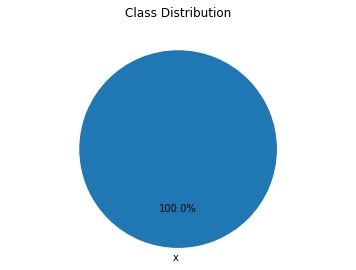

In [46]:
for f in df.index:
    rate, signal = wavfile.read('test_clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

#10분의 1로 데이터를 자름
n_samples = 2 * int(df['length'].sum()/0.1)
prob_dist = class_dist / class_dist.sum()
#카테고리 하나 랜덤으로 뽑아옴
choices = np.random.choice(class_dist.index, p= prob_dist)

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [47]:
config = Config(mode='conv')

In [48]:
x,y = build_rand_feat()
y_flat = np.argmax(y, axis=1)
input_shape = (x.shape[1], x.shape[2], 1)
#test = get_conv_model()

100%|███████████████████████████████████████████████████████████████████████████████| 212/212 [00:01<00:00, 209.77it/s]


In [49]:
len(x)

212

In [18]:
from keras.models import load_model
model = load_model('ver1.0.h5')

In [50]:
pre=model.predict_classes(x)

In [51]:
model.predict(x)

array([[9.9841261e-01, 1.5845993e-03, 1.5696241e-06, ..., 6.2414376e-09,
        4.7310316e-09, 1.7823288e-08],
       [8.4126937e-01, 1.5865371e-01, 3.3482342e-05, ..., 9.4259468e-07,
        7.2795854e-07, 7.4080208e-07],
       [9.5351070e-02, 9.0458077e-01, 2.8831129e-05, ..., 1.8473199e-06,
        1.2740279e-06, 2.2390400e-06],
       ...,
       [4.0317222e-01, 5.9680051e-01, 1.3925227e-05, ..., 7.7315644e-07,
        1.4071432e-07, 1.5403931e-07],
       [6.7554235e-01, 3.2444745e-01, 6.6178304e-06, ..., 5.4805692e-08,
        4.6193378e-08, 6.1030882e-08],
       [9.7837114e-01, 2.1613333e-02, 7.5489938e-06, ..., 7.1487079e-08,
        3.3723762e-08, 8.3126480e-08]], dtype=float32)

In [52]:
pre

array([0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0], dtype=int64)

In [39]:
list1=[4, 4, 4, 2, 7, 4, 6, 3, 0, 4, 3, 4, 4, 4, 8, 3, 4, 3, 3, 3, 4, 3,
       3, 3, 2, 2, 3, 3, 2, 0, 7, 4, 2, 8, 5, 5, 4, 5, 3, 7, 4, 3, 7, 3,
       4, 4, 2, 2, 4, 4, 2, 0, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2,
       4, 4, 2, 4, 5, 2, 3, 5, 4, 3, 3, 3, 4, 3, 3, 3, 4, 4, 3, 4, 3, 3,
       4, 4, 3, 5, 4, 3, 0, 2, 3, 3, 4, 2, 3, 2, 4, 3, 2, 2, 3, 4, 4, 5,
       4, 2]

In [40]:
print(list1.count(0))

4


In [41]:
print(list1.count(1))

0


In [42]:
print(list1.count(2))

20


In [43]:
print(list1.count(3))

41


In [44]:
print(list1.count(4))

33


In [45]:
print(list1.count(5))

7


In [46]:
print(list1.count(6))

1


In [47]:
print(list1.count(7))

4


In [48]:
print(list1.count(8))

2


In [49]:
print(list1.count(9))

0


# 알파벳 순으로 숫자가 결정됨.


# 기타
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)


# 베이스 드럼
array([1, 1, 2, 1, 2, 1, 2, 4, 2, 4, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1,
       2, 4, 2, 2, 1, 0, 1, 1, 2, 4, 1, 2, 1, 2, 2, 2, 1, 4, 2, 1, 1, 1,
       2, 2, 2, 4, 2, 1, 1, 1, 1, 1, 4, 2], dtype=int64)

# 첼로

array([2, 2, 2, 2, 2, 2, 5, 2, 2, 0, 2, 2, 0, 2, 2, 5, 0, 2, 2, 2, 0, 2,
       2, 2, 5, 0, 2, 2, 0, 2, 2, 2, 2, 5, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 5, 3, 2, 2, 5, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2,
       0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 5, 2, 0, 2, 0, 0, 2,
       2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 5,
       0, 5, 2, 2, 2, 2, 0, 5, 2, 2, 2, 5], dtype=int64)
       
  
# 클라리넷
array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3,
       3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3,
       5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3], dtype=int64)
       


# 더블베이스
array([4, 0, 0, 4, 0, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 0, 4, 4, 0, 4,
       4, 4, 4, 4, 4, 4, 0, 4, 4, 5, 0, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 0], dtype=int64)


# 플루트
array([0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int64)
       
       
# 하이햇

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=int64)


# 섹소폰
array([7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 7, 1, 7, 7, 7, 7, 7, 7, 4, 5, 7,
       7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 5, 7, 7, 4, 7, 7, 4, 7, 5, 7, 7, 7, 7, 7, 5, 7, 7, 7, 5, 4,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7, 7, 7, 4, 7], dtype=int64)




# 스네어 드럼
array([8, 8, 8, 8, 3, 8], dtype=int64)


  
# 바이올린
array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], dtype=int64)


